### Imports

In [1]:
first_time_importing_torch = True

In [2]:
import os

# NOTE: Importing torch the first time will always take a long time!
import time
# NOTE: Importing torch the first time will always take a long time!
if first_time_importing_torch:
    print(f"Importing torch ...")
    import_torch_start_time = time.time() 
import torch
if first_time_importing_torch:
    import_torch_end_time = time.time()
    print(f"Importing torch took {import_torch_end_time - import_torch_start_time} seconds")
    first_time_importing_torch = False

import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.data import Dataset

# from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

from skimage.metrics import structural_similarity
# from skimage.metrics import peak_signal_noise_ratio

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import datetime

from PIL import Image

# Optional
from tqdm import tqdm # progress bar

import wandb # Optional, for logging

import json
import yaml

Importing torch ...
Importing torch took 16.426466941833496 seconds


In [3]:
!which python
print(f"Torch version: {torch.__version__}")
print(f"Path: {os.getcwd()}")

/mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/venv/bin/python
Torch version: 2.3.0+cu121
Path: /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/src


In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# DISABLING_TESTS = False
DISABLING_TESTS = True   # Disable tests for less output

### Use GPU

In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"Using {torch.backends.mps.get_device_name(0)} with MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

torch.set_default_device(DEVICE)

Using NVIDIA GeForce RTX 4090


### CONFIG

In [7]:
SIDD_DATA_PATH = "../data/dyn_img_static/tmp/SIDD_Small_sRGB_Only/Data"

In [8]:
CHEST_XRAY_BASE_DATA_PATH = "../data/chest_xray"

In [61]:
def get_config():
    CHEST_XRAY_BASE_DATA_PATH = "../data/chest_xray"
    return {
        "project": "chest_xray",
        "dataset": CHEST_XRAY_BASE_DATA_PATH,
        "train_data_path": f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL",
        "val_data_path": f"{CHEST_XRAY_BASE_DATA_PATH}/val/NORMAL",
        "test_data_path": f"{CHEST_XRAY_BASE_DATA_PATH}/test/NORMAL",
        "train_num_samples": 1,
        "val_num_samples": 1,
        "test_num_samples": 1,

        # "patch": 512,
        # "stride": 512,
        "resize_square": 256,
        "min_sigma": 0.5,
        "max_sigma": 0.5,
        "batch_size": 1,
        "random_seed": 42,

        "architecture": "UNET-PDHG",
        "in_channels": 1,
        "out_channels": 2,
        "init_filters": 32,
        "n_blocks": 3,
        "activation": "LeakyReLU",
        "downsampling_kernel": (2, 2),
        "downsampling_mode": "max",
        "upsampling_kernel": (2, 2),
        "upsampling_mode": "linear_interpolation",

        "optimizer": "Adam",
        "learning_rate": 1e-4,
        "loss_function": "MSELoss",

        # "up_bound": 0.5,
        "up_bound": 0,
        "T": 32, # Higher T, NET does not have to try as hard? Less overfitting?

        "epochs": 2,
        "device": "cuda:0",

        "wandb_mode": "online",
        "save_epoch_wandb": 10_000,
        "save_epoch_local": 10,
        "save_dir": "tmp_2",
    }

print(get_config())

{'project': 'chest_xray', 'dataset': '../data/chest_xray', 'train_data_path': '../data/chest_xray/train/NORMAL', 'val_data_path': '../data/chest_xray/val/NORMAL', 'test_data_path': '../data/chest_xray/test/NORMAL', 'train_num_samples': 1, 'val_num_samples': 1, 'test_num_samples': 1, 'resize_square': 256, 'min_sigma': 0.5, 'max_sigma': 0.5, 'batch_size': 1, 'random_seed': 42, 'architecture': 'UNET-PDHG', 'in_channels': 1, 'out_channels': 2, 'init_filters': 32, 'n_blocks': 3, 'downsampling_kernel': (2, 2), 'downsampling_mode': 'max', 'upsampling_kernel': (2, 2), 'upsampling_mode': 'linear_interpolation', 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'learning_rate': 0.0001, 'loss_function': 'MSELoss', 'up_bound': 0, 'T': 32, 'epochs': 2, 'device': 'cuda:0', 'wandb_mode': 'online', 'save_epoch_wandb': 10000, 'save_epoch_local': 10, 'save_dir': 'tmp_2'}


------

### Import the image and transform the data

#### Download the data

In [10]:
# # REMEMBER TO COMMENT THIS OUT IF THE DATA HAS BEEN DOWNLOADED!
# !wget https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2
# !unzip "a26784fe-cf33-48c2-b61f-94b299dbc0f2" -d .

#### Load SIDD images

In [11]:
def get_npy_file(sample_path: str, scale_factor: float) -> np.ndarray:			
    scale_factor_str = str(scale_factor).replace('.','_')
    xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
    xf = torch.tensor(xf, dtype=torch.float)
    xf = xf.unsqueeze(0) / 255
    return xf

In [12]:
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
def load_images_SIDD(ids: list, take_npy_files: bool) -> list:
    data_path = SIDD_DATA_PATH
    k = 0

    images = []

    for folder in os.listdir(data_path):
        img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
        if img_id not in ids:
            continue
        k += 1
        print(f'loading image id {img_id}, {k}/{len(ids)}')

        files_path = os.path.join(data_path, folder)

        # if take_npy_files:
        #     xf = get_npy_file(files_path, scale_factor)
        #     images.append(xf)
        #     continue

        # Use only the ground truth images
        file = "GT_SRGB_010.PNG"  # GT = Ground Truth

        image = Image.open(os.path.join(files_path, file))
        assert image.mode == 'RGB', f"Image mode is not RGB: {image.mode}" # For now, expect RGB images

        images.append(image)

    return images

In [13]:
def test_load_images_SIDD():
    if DISABLING_TESTS: return
    for img in load_images_SIDD(["0065"], False):
        print(img.size)
        plt.imshow(img)

test_load_images_SIDD()

#### Load Chest X-ray images

In [14]:
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
def load_images_chest_xray(data_path: str, ids: list) -> list:
    files = os.listdir(data_path)
    jpeg_files = [f for f in files if f.endswith(".jpeg")]

    images = []
    for id in tqdm(ids):
        if id >= len(jpeg_files): continue
        # print(f"Loading image {id} from {data_path}")
        image = Image.open(os.path.join(data_path, jpeg_files[id]))
        images.append(image)
    
    return images

In [15]:
def test_load_images_chest_xray(stage="train", label="NORMAL"):
    if DISABLING_TESTS: return
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/{stage}/{label}", [0]):
        print(img.size)
        plt.imshow(img, cmap='gray')
    plt.show();

test_load_images_chest_xray()

------

#### Convert image to grayscale

In [16]:
def convert_to_grayscale(image: Image) -> Image:
    return image.convert('L')

In [17]:
def test_convert_to_grayscale():
    if DISABLING_TESTS: return
    # for img in load_images_SIDD(["0065"], False):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        img = convert_to_grayscale(img)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_convert_to_grayscale()

#### Transform image

In [18]:
def crop_to_square(image: Image) -> Image:
    width, height = image.size
    new_size = min(width, height)
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2
    return image.crop((left, top, right, bottom))

In [19]:
def test_crop_to_square():
    if DISABLING_TESTS: return
    # for img in load_images_SIDD(["0083"], False):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        plt.imshow(img, cmap='gray')
        plt.show();
        img = crop_to_square(img)
        plt.imshow(img, cmap='gray')
        plt.show();

test_crop_to_square()

In [20]:
def crop_to_square_and_resize(image: Image, side_len: int) -> Image:
    image = crop_to_square(image)
    return image.resize(size=(side_len, side_len))

In [21]:
def test_crop_to_square_and_resize():
    if DISABLING_TESTS: return
    # for img in load_images_SIDD(["0083"], False):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        plt.imshow(img, cmap='gray')
        plt.show();
        img = crop_to_square_and_resize(img, 120)
        print(img.size)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.
        plt.show();

test_crop_to_square_and_resize()

#### Convert to numpy array

In [22]:
def convert_to_numpy(image):
    image_data = np.asarray(image)
    return image_data

In [23]:
def test_convert_to_numpy():
    if DISABLING_TESTS: return
    # for img in load_images_SIDD(["0083"], False):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        img = convert_to_grayscale(img)
        print(f"Before conversion: {type(img)}")
        image_data = convert_to_numpy(img)
        print(f"After conversion: {type(image_data)}")
        # plt.imshow still works with numpy array
        plt.imshow(image_data, cmap='gray')

test_convert_to_numpy()

#### Convert to tensor

For efficient computation on GPU

In [24]:
def convert_to_tensor_4D(image_numpy):
    # xf = []
    # xf.append(image_numpy)
    # xf = np.stack(xf, axis=-1)
    # xf = torch.tensor(xf, dtype=torch.float)
    xf = torch.tensor(image_numpy, dtype=torch.float)
    xf = xf.unsqueeze(0)
    xf = xf.unsqueeze(-1)
    xf = xf / 255 # Normalise from [0, 255] to [0, 1]
    return xf

In [25]:
def test_convert_to_tensor():
    if DISABLING_TESTS: return
    # for image in load_images_SIDD(["0083"], False):
    for image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        image = convert_to_grayscale(image)
        image_numpy = convert_to_numpy(image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        print(image_tensor_4D.size())
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')

    with torch.no_grad():
        torch.cuda.empty_cache()

test_convert_to_tensor()

#### Add synthetic noise

<!-- artificial Gaussian noise

Noise can occur in reality.

It is difficult to obtain a pair of clean and noisy images of one exact same scene.

For training, it is common to add synthetic noise to an image that is considered clean and then try to reconstruct it.

There are many types of noise and different ways to add noise. We can add salt-and-pepper noise. (?)We can add more noise in some parts and less in others. We can use a combination of noise-adding strategies to build more robust models.

For our purpose, we will focus on Gaussian noise. This is sufficient for most cases. 

(?) We will add noise with the same probability for each pixel (not using the strategies of focusing on certain regions) -->

In [26]:
def get_variable_noise(sigma_min, sigma_max):
    return sigma_min + torch.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: torch.tensor, sigma) -> torch.tensor:
    std = torch.std(xf)
    mu = torch.mean(xf)

    x_centred = (xf  - mu) / std

    x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)

    xnoise = std * x_centred + mu

    return xnoise

In [27]:
def test_add_noise():
    if DISABLING_TESTS: return
    # for rgb_image in load_images_SIDD(["0083"], False):
    for rgb_image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = crop_to_square_and_resize(grayscale_image, 120)
        print(f"grayscale_image.size: {grayscale_image.size}")
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        constant_noise_img = add_noise(image_tensor_4D, sigma=0.1)
        variable_noise_img = add_noise(image_tensor_4D, get_variable_noise(
            sigma_min=0.1, sigma_max=0.2))
        plt.imshow(grayscale_image, cmap='gray')
        plt.show();
        plt.imshow(constant_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();
        plt.imshow(variable_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()
        
test_add_noise()

------

### Calculate PSNR

PSNR is a common metrics for noisy image.

Compare before and after adding synthetic noise

In [28]:
def PSNR(original, compressed): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0): # MSE is zero means no noise is present in the signal. 
                  # Therefore PSNR have no importance. 
        return 100
    # max_pixel = 255.0
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse)) 
    return psnr

In [29]:
def test_PSNR():
    if DISABLING_TESTS: return
    # for rgb_image in load_images_SIDD(["0083"], False):
    for rgb_image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = crop_to_square_and_resize(grayscale_image, 120)
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)

        print(f"PSNR of original image: {PSNR(image_tensor_4D, image_tensor_4D)} dB")
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        noisy_image_tensor_4D = add_noise(image_tensor_4D, sigma=0.5)
        print(f"PSNR of constant noise image: {PSNR(noisy_image_tensor_4D, image_tensor_4D):.2f} dB")
        plt.imshow(noisy_image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

test_PSNR()

---

### Calculate SSIM

In [30]:
def SSIM(tensor_2D_a: torch.Tensor, tensor_2D_b: torch.Tensor, data_range: float=1) -> float:
    return structural_similarity(
        tensor_2D_a.to("cpu").detach().numpy(), 
        tensor_2D_b.to("cpu").detach().numpy(),
        data_range=data_range)

In [31]:
def test_SSIM(sigma=0.5):
    if DISABLING_TESTS: return
    # for rgb_image in load_images_SIDD(["0083"], False):
    for rgb_image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = crop_to_square_and_resize(grayscale_image, 120)
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)

        image_tensor_2D = image_tensor_4D.squeeze(0).squeeze(-1)
        print(f"image_tensor_2D: {image_tensor_2D.size()}")
        print(f"SSIM of original image: {SSIM(image_tensor_2D, image_tensor_2D)}")
        plt.imshow(image_tensor_2D.cpu(), cmap='gray')
        plt.show();

        noisy_image_tensor_2D = add_noise(image_tensor_2D, sigma=sigma)
        print(f"noisy_image_tensor_2D: {noisy_image_tensor_2D.size()}")
        print(f"SSIM of noisy image (sigma={sigma}): {SSIM(noisy_image_tensor_2D, image_tensor_2D):.2f}")
        plt.imshow(noisy_image_tensor_2D.cpu(), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

test_SSIM()

------

### Reconstruct an image with PDHG

#### Calculate the gradient

<!-- The gradient is a Laplacian ?

There are $x$ gradient and $y$ gradient -->

In [32]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class GradOperators(torch.nn.Module):
    @staticmethod
    def diff_kernel(ndim, mode):
        if mode == "doublecentral":
            kern = torch.tensor((-1, 0, 1))
        elif mode == "central":
            kern = torch.tensor((-1, 0, 1)) / 2
        elif mode == "forward":
            kern = torch.tensor((0, -1, 1))
        elif mode == "backward":
            kern = torch.tensor((-1, 1, 0))
        else:
            raise ValueError(f"mode should be one of (central, forward, backward, doublecentral), not {mode}")
        kernel = torch.zeros(ndim, 1, *(ndim * (3,)))
        for i in range(ndim):
            idx = tuple([i, 0, *(i * (1,)), slice(None), *((ndim - i - 1) * (1,))])
            kernel[idx] = kern
        return kernel

    def __init__(self, dim:int=2, mode:str="doublecentral", padmode:str = "circular"):
        """
        An Operator for finite Differences / Gradients
        Implements the forward as apply_G and the adjoint as apply_GH.
        
        Args:
            dim (int, optional): Dimension. Defaults to 2.
            mode (str, optional): one of doublecentral, central, forward or backward. Defaults to "doublecentral".
            padmode (str, optional): one of constant, replicate, circular or refelct. Defaults to "circular".
        """
        super().__init__()
        self.register_buffer("kernel", self.diff_kernel(dim, mode), persistent=False)
        self._dim = dim
        self._conv = (torch.nn.functional.conv1d, torch.nn.functional.conv2d, torch.nn.functional.conv3d)[dim - 1]
        self._convT = (torch.nn.functional.conv_transpose1d, torch.nn.functional.conv_transpose2d, torch.nn.functional.conv_transpose3d)[dim - 1]
        self._pad = partial(torch.nn.functional.pad, pad=2 * dim * (1,), mode=padmode)
        if mode == 'central':
            self._norm = (self.dim) ** (1 / 2)
        else:
            self._norm = (self.dim * 4) ** (1 / 2)

    @property
    def dim(self):
        return self._dim
    
    def apply_G(self, x):
        """
        Forward
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim], self.dim, *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[0 : -self.dim], self.dim, *x.shape[-self.dim :])
        return y

    def apply_GH(self, x):
        """
        Adjoint
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, self.dim, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._convT(xp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim - 1], *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[: -self.dim - 1], *x.shape[-self.dim :])
        return y
    
    def apply_GHG(self, x):
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        tmp = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        tmp = self._pad(tmp)
        y = self._convT(tmp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape)
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape)
        return y

    def forward(self, x, direction=1):
        if direction>0:
            return self.apply_G(x)
        elif direction<0:
            return self.apply_GH(x)
        else:
            return self.apply_GHG(x)

    @property
    def normGHG(self):
        return self._norm

#### Helper function for PDHG: Clip act

In [33]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class ClipAct(nn.Module):
    def forward(self, x, threshold):
        return clipact(x, threshold)


def clipact(x, threshold):
    is_complex = x.is_complex()
    if is_complex:
        x = torch.view_as_real(x)
        threshold = threshold.unsqueeze(-1)
    x = torch.clamp(x, -threshold, threshold)
    if is_complex:
        x = torch.view_as_complex(x)
    return x

#### Only PDHG

For some reason, running PDHG with T large (many iterations in PDGH) will make GPU memory full?

In [34]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

def reconstruct_with_PDHG(x_dynamic_image_tensor_5D, lambda_reg, T, lambda_reg_container=[]):
    """
    Reconstructs the image using the PDHG algorithm.

    Parameters:
        dynamic_image_tensor_5D: The (noisy) (dynamic) image tensor.
        Size of the tensor: (`patches`, `channels`, `Nx`, `Ny`, `Nt`) where
        
        - `patches`: number of patches
        - `channels`: number of (colour) channels
        - `Nx`: number of pixels in x
        - `Ny`: number of pixels in y
        - `Nt`: number of time steps (frames)

        lambda_reg: The regularization parameter. Can be a scalar or a tensor of suitable size.
        T: Number of iterations.

    Returns:
        The reconstructed image tensor.
    """

    dim = 3
    patches, channels, Nx, Ny, Nt = x_dynamic_image_tensor_5D.shape
    
    assert channels == 1, "Only grayscale images are supported."

    device = x_dynamic_image_tensor_5D.device

    # starting values
    xbar = x_dynamic_image_tensor_5D.clone()
    x0 = x_dynamic_image_tensor_5D.clone()
    xnoisy = x_dynamic_image_tensor_5D.clone()

    # dual variable
    p = x_dynamic_image_tensor_5D.clone()
    q = torch.zeros(patches, dim, Nx, Ny, Nt, dtype=x_dynamic_image_tensor_5D.dtype).to(device)

    # operator norms
    op_norm_AHA = torch.sqrt(torch.tensor(1.0))
    op_norm_GHG = torch.sqrt(torch.tensor(12.0))
    # operator norm of K = [A, \nabla]
    # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
    # see page 3083
    L = torch.sqrt(op_norm_AHA**2 + op_norm_GHG**2)

    tau = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L
    sigma = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L

    # theta should be in \in [0,1]
    theta = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1

    # sigma, tau, theta
    sigma = (1 / L) * torch.sigmoid(sigma)  # \in (0,1/L)
    tau = (1 / L) * torch.sigmoid(tau)  # \in (0,1/L)
    theta = torch.sigmoid(theta)  # \in (0,1)

    GradOps = GradOperators(
        dim=dim, 
        mode="forward", padmode="circular")
    clip_act = ClipAct()
    # Algorithm 2 - Unrolled PDHG algorithm (page 18)
    # TODO: In the paper, L is one of the inputs but not used anywhere in the pseudo code???
    for kT in range(T):
        # update p
        p =  (p + sigma * (xbar - xnoisy) ) / (1. + sigma)
        # update q
        q = clip_act(q + sigma * GradOps.apply_G(xbar), lambda_reg)

        x1 = x0 - tau * p - tau * GradOps.apply_GH(q)

        if kT != T - 1:
            # update xbar
            xbar = x1 + theta * (x1 - x0)
            x0 = x1
        with torch.no_grad():
            torch.cuda.empty_cache()

    with torch.no_grad():
        torch.cuda.empty_cache()

    lambda_reg_container.append(lambda_reg) # For comparison

    return x1

In [35]:
def test_reconstruct_with_PDHG():
    if DISABLING_TESTS: return
    # for rgb_image in load_images_SIDD(["0083"], False):
    for rgb_image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = crop_to_square_and_resize(grayscale_image, 512)
        image_numpy = convert_to_numpy(grayscale_image)

        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        print(f"Image tensor size: {image_tensor_4D.size()}")
        assert len(image_tensor_4D.size()) == 4, "The image should be 4D"
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_SIGMA = 0.5  # Relatively high noise
        noisy_image_tensor_4D = add_noise(image_tensor_4D, sigma=TEST_SIGMA)
        print(f"PSNR of constant noise image: {PSNR(image_tensor_4D, noisy_image_tensor_4D):.2f} dB")
        print(f"SSIM of constant noise image: {SSIM(image_tensor_4D.squeeze(0).squeeze(-1), noisy_image_tensor_4D.squeeze(0).squeeze(-1)):.2f}")
        plt.imshow(noisy_image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_LAMBDA = 0.04
        pdhg_input_tensor_5D = noisy_image_tensor_4D.unsqueeze(0)
        print(f"PDHG input size: {pdhg_input_tensor_5D.size()}")
        assert len(pdhg_input_tensor_5D.size()) == 5, "The input for PDHG should be 5D"
        denoised_image_tensor_5D = reconstruct_with_PDHG(
            pdhg_input_tensor_5D, 
            lambda_reg=TEST_LAMBDA, 
            T=128)
        
        denoised_image_tensor_5D = torch.clamp(denoised_image_tensor_5D, 0, 1) # Clip the values to 0 and 1
        psnr_value_denoised = PSNR(image_tensor_4D, denoised_image_tensor_5D.squeeze(0))
        print(f"PSNR of reconstructed image: {psnr_value_denoised:.2f} dB")
        denoised_image_numpy_3D = denoised_image_tensor_5D.squeeze(0).squeeze(0).to("cpu").detach().numpy()
        plt.imshow(denoised_image_numpy_3D, cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

    print("""
In this example, a lot of noise has been applied to the original image. The PDHG algorithm tries to reconstruct the image from the noisy image. It did remove some noise and improved the PSNR value. However, the quality has been degraded significantly. We will see whether we can improve this by learning a set of parameters map.
""")
    
    # The lambda parameter is the regularization parameter. The higher the lambda, the more the regularization. The T parameter is the number of iterations. The higher the T, the more the iterations. The PSNR value is the Peak Signal to Noise Ratio. The higher the PSNR, the better the reconstruction.

test_reconstruct_with_PDHG()

------

### Full Architecture

<!-- UNET to PDHG

The whole architecture can be seen as unsupervised: The data only contains (clean) images.

The whole model: Input is an image. Output is also an image.

The UNET actually only outputs the regularisation parameter map. -->

In [36]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class DynamicImageStaticPrimalDualNN(nn.Module):
    def __init__(
        self,
        T=128,
        cnn_block=None,
        mode="lambda_cnn",
        up_bound=0,
        phase="training",
    ):
        # print(f"Running: {DynamicImageStaticPrimalDualNN.__name__}")
        super(DynamicImageStaticPrimalDualNN, self).__init__()

        # gradient operators and clipping function
        dim = 3
        self.GradOps = GradOperators(dim, mode="forward", padmode="circular")

        # operator norms
        self.op_norm_AHA = torch.sqrt(torch.tensor(1.0))
        self.op_norm_GHG = torch.sqrt(torch.tensor(12.0))
        # operator norm of K = [A, \nabla]
        # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
        # see page 3083
        self.L = torch.sqrt(self.op_norm_AHA**2 + self.op_norm_GHG**2)

        # function for projecting
        self.ClipAct = ClipAct()

        if mode == "lambda_xyt":
            # one single lambda for x,y and t
            self.lambda_reg = nn.Parameter(torch.tensor([-1.5]), requires_grad=True)

        elif mode == "lambda_xy_t":
            # one (shared) lambda for x,y and one lambda for t
            self.lambda_reg = nn.Parameter(
                torch.tensor([-4.5, -1.5]), requires_grad=True
            )

        elif mode == "lambda_cnn":
            # the CNN-block to estimate the lambda regularization map
            # must be a CNN yielding a two-channeld output, i.e.
            # one map for lambda_cnn_xy and one map for lambda_cnn_t
            self.cnn = cnn_block    # NOTE: This is actually the UNET!!! (At least in this project)
            self.up_bound = torch.tensor(up_bound)

        # number of terations
        self.T = T
        self.mode = mode

        # constants depending on the operators
        self.tau = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L
        self.sigma = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L

        # theta should be in \in [0,1]
        self.theta = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1

        # distinguish between training and test phase;
        # during training, the input is padded using "reflect" padding, because
        # patches are used by reducing the number of temporal points;
        # while testing, "reflect" padding is used in x,y- direction, while
        # circular padding is used in t-direction
        self.phase = phase

    def get_lambda_cnn(self, x):
        # padding
        # arbitrarily chosen, maybe better to choose it depending on the
        # receptive field of the CNN or so;
        # seems to be important in order not to create "holes" in the
        # lambda_maps in t-direction
        npad_xy = 4
        # npad_t = 8
        npad_t = 0 # TODO: Time dimension should not be necessary for single image input.
        # I changed the npad_t to 0 so that I can run on single image input without change the 3D type config. It seems that the number of frames must be greater than npad_t?

        pad = (npad_t, npad_t, npad_xy, npad_xy, npad_xy, npad_xy)

        if self.phase == "training":
            x = F.pad(x, pad, mode="reflect")

        elif self.phase == "testing":
            pad_refl = (0, 0, npad_xy, npad_xy, npad_xy, npad_xy)
            pad_circ = (npad_t, npad_t, 0, 0, 0, 0)

            x = F.pad(x, pad_refl, mode="reflect")
            x = F.pad(x, pad_circ, mode="circular")

        # estimate parameter map
        lambda_cnn = self.cnn(x) # NOTE: The cnn is actually the UNET block!!! (At least in this project)

        # crop
        neg_pad = tuple([-pad[k] for k in range(len(pad))])
        lambda_cnn = F.pad(lambda_cnn, neg_pad)

        # double spatial map and stack
        lambda_cnn = torch.cat((lambda_cnn[:, 0, ...].unsqueeze(1), lambda_cnn), dim=1)

        # constrain map to be striclty positive; further, bound it from below
        if self.up_bound > 0:
            # constrain map to be striclty positive; further, bound it from below
            lambda_cnn = self.up_bound * self.op_norm_AHA * torch.sigmoid(lambda_cnn)
        else:
            lambda_cnn = 0.1 * self.op_norm_AHA * F.softplus(lambda_cnn)

        return lambda_cnn

    def forward(self, x, lambda_map=None, lambda_reg_container=[]):
        if lambda_map is None:
            # estimate lambda reg from the image
            lambda_reg = self.get_lambda_cnn(x)
        else:
            lambda_reg = lambda_map

        lambda_reg_container.append(lambda_reg) # For comparison

        x.to(DEVICE)
        x1 = reconstruct_with_PDHG(x, lambda_reg, self.T)
        return x1

------

### Data loading class

In [37]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class DynamicImageStaticDenoisingDataset(Dataset):
	
	def __init__(
		self, 
		data_path: str, 
		ids: list,
		# scale_factor = 0.5, 
		# patches_size = None,
		# strides= None,
		resize_square = 120,
		sigma = (0.1, 0.5),  
		device: str = "cuda"
	):
		self.device = device
		# self.scale_factor = scale_factor
		self.resize_square = resize_square

		xray_images = load_images_chest_xray(data_path, ids)

		xf_list = []
		for image in xray_images:
			image = crop_to_square_and_resize(image, self.resize_square)
			image = image.convert('L') #convert to grey_scale
			image_data = np.asarray(image)
			xf = torch.tensor(image_data, dtype=torch.float)
			# Assume image is in [0, 255] range
			xf = xf / 255
			assert len(xf.size()) == 2, f"Expected 2D tensor, got {xf.size()}"
			xf = xf.unsqueeze(0) # Add channel dimension
			xf = xf.unsqueeze(-1) # Add time dimension. TODO: For legacy dynamic image code only. Will remove later.
			xf_list.append(xf)
		xf = torch.stack(xf_list, dim=0) # will have shape (mb, 1, Nx, Ny, Nt), where mb denotes the number of patches
		assert len(xf.size()) == 5, f"Expected 5D tensor, got {xf.size()}"
		assert xf.size(1) == 1, f"Expected 1 channel, got {xf.size(1)}"
		assert xf.size(2) == self.resize_square, f"Expected width (Nx) of {self.resize_square}, got {xf.size(-3)}"
		assert xf.size(3) == self.resize_square, f"Expected height (Ny) of {self.resize_square}, got {xf.size(-2)}"
		assert xf.size(4) == 1, f"Expected 1 time step, got {xf.size(-1)}"

		#create temporal TV vector to detect which patches contain the most motion
		xf_patches_tv = (xf[...,1:] - xf[...,:-1]).pow(2).sum(dim=[1,2,3,4]) #contains the TV for all patches
		
		#normalize to 1 to have a probability vector
		xf_patches_tv /= torch.sum(xf_patches_tv)
		
		#sort TV in descending order --> xfp_tv_ids[0] is the index of the patch with the most motion
		self.samples_weights = xf_patches_tv

		# TODO: Investigate
		# Change the values in samples_weights to be a range of integers from 0 to len(samples_weights)
		# Unless I do this, when I run on a set of identical images, it will give me an error:
		# RuntimeError: invalid multinomial distribution (encountering probability entry < 0)
		self.samples_weights = torch.arange(len(self.samples_weights))
		
		self.xf = xf
		self.len = xf.shape[0]
		
		self.sigma_min = sigma[0]
		self.sigma_max = sigma[1]
		
			
	def __getitem__(self, index):

		sigma = self.sigma_min + torch.rand(1) * ( self.sigma_max - self.sigma_min )

		x_noise = add_noise(self.xf[index], sigma)

		return (
			x_noise.to(device=self.device),
   			self.xf[index].to(device=self.device)
        )
		
	def __len__(self):
		return self.len

------

### UNET

The specific UNET architecture we use has the following parts:

...

We use Leaky RELU instead of RELU or Sigmoid.

In [45]:
# Used https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py as a reference

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation="LeakyReLU"):
        super(DoubleConv2d, self).__init__()

        def get_activation():
            # Try not to use inplace operations since we have skip connections?
            if activation == "LeakyReLU":
                return nn.LeakyReLU(negative_slope=0.01, inplace=False)
            elif activation == "ReLU":
                return nn.ReLU(inplace=False)
            else:
                raise ValueError(f"Unsupported activation function: {activation}")

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)), 
            get_activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)), 
            get_activation())

    def forward(self, x: torch.Tensor):
        return self.conv_block(x)
        

class EncodeBlock2d(nn.Module):
    def __init__(
            self, in_channels: int, activation="LeakyReLU",
            downsampling_kernel=(2, 2), downsampling_mode="max"):
        super(EncodeBlock2d, self).__init__()

        len = downsampling_kernel[0] # Assume kernel has shape (len, len)
        assert downsampling_kernel == (len, len), f"Expected a square kernel like {(len, len)}, got {downsampling_kernel}"
        stride = (2, 2) # Stride 2x2 to halve each side 
        padding = ((len-1)//2, (len-1)//2) # Padding (len-1) // 2 to exactly halve each side 
        if downsampling_mode == "max":
            self.pool = nn.MaxPool2d(
                kernel_size=downsampling_kernel, stride=stride, padding=padding)
        elif downsampling_mode == "avg":
            self.pool = nn.AvgPool2d(
                kernel_size=downsampling_kernel, stride=stride, padding=padding)
        else:
            raise ValueError(f"Unknown pooling method: {downsampling_mode}")

        self.double_conv = DoubleConv2d(in_channels, in_channels * 2, activation)

    def forward(self, x: torch.Tensor):
        x = self.pool(x)
        x = self.double_conv(x)
        return x



class DecodeBlock2d(nn.Module):
    def __init__(
            self, in_channels: int, activation="LeakyReLU",
            upsampling_kernel=(2, 2), upsampling_mode="linear_interpolation"):
        super(DecodeBlock2d, self).__init__()

        if upsampling_mode == "linear_interpolation":
            self.upsampling = nn.Sequential(
                nn.Upsample(
                    scale_factor=(2, 2), # Assume the shape is (H, W) where W is the image width and H is the image height.
                    mode='bilinear', align_corners=True), # What difference does it make in the end if align_corners is True or False? Preserving symmetry?
                # 1x1 convolution to reduce the number of channels while keeping the size the same
                nn.Conv2d(
                    in_channels, in_channels // 2, 
                    kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
            )
        elif upsampling_mode == "transposed_convolution":  
            len = upsampling_kernel[0] # Assume kernel has shape (len, len)
            assert upsampling_kernel == (len, len), f"Expected a square kernel like {(len, len)}, got {upsampling_kernel}"
            stride = (2, 2) # Stride 2x2 to double each side 
            padding = ((len-1)//2, (len-1)//2) # Padding (len-1) // 2 to exactly double each side    
            self.upsampling = nn.ConvTranspose2d(
                in_channels, in_channels // 2, 
                kernel_size=upsampling_kernel, stride=stride, padding=padding, 
                output_padding=padding # TODO: Should this be the same as padding?
            )
        else:
            raise ValueError(f"Unsupported upsampling method: {upsampling_mode}")
        
        self.double_conv = DoubleConv2d(in_channels, in_channels // 2, activation)

    def forward(self, x: torch.Tensor, x_encoder_output: torch.Tensor):
        x = self.upsampling(x)
        x = torch.cat([x_encoder_output, x], dim=1)   # skip-connection. No cropping since we ensure that the size is the same.
        x = self.double_conv(x)
        return x



class UNet2d(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=2, init_filters=32, n_blocks=3,
            activation="LeakyReLU",
            downsampling_kernel=(2, 2), downsampling_mode="max",
            upsampling_kernel=(2, 2), upsampling_mode="linear_interpolation",
    ):
        """
        Assume that input is 4D tensor of shape (N, C, H, W) or 3D tensor of shape (C, H, W)
        where W is the image width, H is the image height, C is the number of channels, and N is the batch size.
        Aslo assume that N = 1, C = 1, and H = W (square image).
        "channels" is equivalent to the number of "filters" or "features".

        Our paper (figure 2):
            - in_channels = 1
            - out_channels = 2
            - init_filters = 32
            - n_blocks = 3
            - pooling: max pooling 2x2
            - pool padding = 1
                - 1 padding will keep the size of the "image" the same after each convolution. The skip-connection will NOT crop the encoder's output.
            - upsampling kernel: 2x2 ?
            - up_mode: linear interpolation

        U-Net paper (2015, Olaf Ronneberger https://arxiv.org/abs/1505.04597):
            - in_channels = 1
            - out_channels = 2
            - init_filters = 64
            - n_blocks = 4
            - pooling: max pooling 2x2
            - pool padding = 0
                - 0 padding will reduce the size of the "image" by 2 in each dimension after each convolution. The skip-connection will have to crop the encoder's output to match the decoder's input.
            - upsampling kernel: 2x2
            - up_mode: ? (linear interpolation or transposed convolution)
        """
        super(UNet2d, self).__init__()
        
        self.c0x0 = DoubleConv2d( # TODO: Find a better name
            in_channels=in_channels, 
            out_channels=init_filters,
            activation=activation,
        )
        self.encoder = nn.ModuleList([
            EncodeBlock2d(
                in_channels=init_filters * 2**i, 
                activation=activation,
                downsampling_kernel=downsampling_kernel,
                downsampling_mode=downsampling_mode
            ) for i in range(n_blocks)
        ])
        self.decoder = nn.ModuleList([
            DecodeBlock2d(
                in_channels=init_filters * 2**(n_blocks-i), 
                activation=activation,
                upsampling_kernel=upsampling_kernel,
                upsampling_mode=upsampling_mode
            ) for i in range(n_blocks)
        ])
        # 1x1x1 convo
        self.c1x1 = nn.Conv2d( # TODO: Find a better name
            in_channels=init_filters,
            out_channels=out_channels,
            kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)
        )

    def forward(self, x: torch.Tensor):
        """
        Assume that input is 4D tensor of shape (N, C, H, W) or 3D tensor of shape (C, H, W)
        where W is the image width, H is the image height, C is the number of channels, and N is the batch size.
        Aslo assume that N = 1, C = 1, and H = W (square image).
        "channels" is equivalent to the number of "filters" or "features".
        """
        n_dim = len(x.size())
        assert n_dim == 4 or n_dim == 3, f"Expected 4D or 3D tensor, got {n_dim}"
        C, H, W = x.size(-3), x.size(-2), x.size(-1)
        if n_dim == 4:
            N = x.size(0)
            assert N == 1, f"Expected batch size 1, got {N}" # TODO: Might train with larger batch size
        assert C == 1, f"Expected 1 channel, got {C}" # TODO: Allow multiple channels (colour images)
        assert W == H, f"Expected square image, got width {W} and height {H}" # TODO: Allow non-square images
        n_blocks = len(self.encoder)
        assert W >= 2**n_blocks, f"Expected width of at least {2**n_blocks}, got {W}"
        assert H >= 2**n_blocks, f"Expected height of at least {2**n_blocks}, got {H}"

        x = self.c0x0(x)

        encoder_outputs = []
        for i, enc_block in enumerate(self.encoder):
            encoder_outputs.append(x)
            x = enc_block(x)
        for i, dec_block in enumerate(self.decoder):
            x = dec_block(x, encoder_outputs[-i-1]) # skip-connection inside
            
        x = self.c1x1(x)
        return x

In [46]:
def assert_and_clear_cuda(expected, actual):
    try:
        assert expected == actual
    except AssertionError:
        print(f"!!! ERROR !!! Expected: {expected}, got {actual}")
        with torch.no_grad():
            torch.cuda.empty_cache()
    

def test_unet_2d():    
    input_tensor_2d = torch.randn(1, 1, 512, 512)  # batch size of 1, 1 channel, 512x512 area
    
    config = get_config()

    # Example usage
    model = UNet2d(
        init_filters=32,
        n_blocks=config["n_blocks"],
        downsampling_kernel=config["downsampling_kernel"],
        downsampling_mode=config["downsampling_mode"],
        upsampling_kernel=config["upsampling_kernel"],
        upsampling_mode=config["upsampling_mode"],
    )
    output = model(input_tensor_2d)
    print(f"UNet output shape: {output.shape}")
    assert_and_clear_cuda((1, 2, 512, 512), output.shape)


    conv_2d = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    conv_2d_output = conv_2d(input_tensor_2d)
    print(f"Conv2d output shape: {conv_2d_output.shape}")
    assert_and_clear_cuda((1, 64, 512, 512), conv_2d_output.shape)


    double_conv_2d = DoubleConv2d(64, 128, activation=config["activation"])
    double_conv_output = double_conv_2d(conv_2d_output)
    print(f"{DoubleConv2d.__name__} output shape: {double_conv_output.shape}")
    assert_and_clear_cuda((1, 128, 512, 512), double_conv_output.shape)


    max_2d = nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1))
    max_2d_output_1 = max_2d(input_tensor_2d)
    print(f"MaxPool2d output 1 shape: {max_2d_output_1.shape}")
    assert_and_clear_cuda((1, 1, 256, 256), max_2d_output_1.shape)

    max_2d_input = torch.randn(1, 128, 512, 512)
    max_2d_output_2 = max_2d(max_2d_input)
    print(f"MaxPool2d output 2 shape: {max_2d_output_2.shape}")
    assert_and_clear_cuda((1, 128, 256, 256), max_2d_output_2.shape)

    conv_transpose_2d = nn.ConvTranspose2d(
        1024, 512, 
        kernel_size=(3, 3), 
        stride=(2, 2), 
        padding=(1, 1), 
        output_padding=(1, 1)
    )
    conv_transpose_2d_input = torch.randn(1, 1024, 32, 32)
    conv_transpose_2d_output = conv_transpose_2d(conv_transpose_2d_input)
    print(f"ConvTranspose2d output shape: {conv_transpose_2d_output.shape}")
    assert_and_clear_cuda((1, 512, 64, 64), conv_transpose_2d_output.shape)


    up_sample = nn.Upsample(
        scale_factor=(2, 2), 
        mode='bilinear', align_corners=True) # What difference does it make if align_corners is True or False?
    up_sample_output = up_sample(input_tensor_2d)
    print(f"Upsample output shape: {up_sample_output.shape}")
    assert_and_clear_cuda((1, 1, 1024, 1024), up_sample_output.shape)
                    

    # # print(f"\n{model}")

    with torch.no_grad():
        torch.cuda.empty_cache()

    # # Delete the model and the output tensor
    # del model
    # del output
    # torch.cuda.empty_cache()

test_unet_2d()
with torch.no_grad():
    torch.cuda.empty_cache()

UNet output shape: torch.Size([1, 2, 512, 512])
Conv2d output shape: torch.Size([1, 64, 512, 512])
DoubleConv2d output shape: torch.Size([1, 128, 512, 512])
MaxPool2d output 1 shape: torch.Size([1, 1, 256, 256])
MaxPool2d output 2 shape: torch.Size([1, 128, 256, 256])
ConvTranspose2d output shape: torch.Size([1, 512, 64, 64])
Upsample output shape: torch.Size([1, 1, 1024, 1024])


In [47]:
with torch.no_grad():
    torch.cuda.empty_cache()

------

### Create data loader

In [48]:
# Code adapted from ...

def get_datasets(config):
    min_sigma = config["min_sigma"]
    max_sigma = config["max_sigma"]
    resize_square = config["resize_square"]
    device = config["device"]

    train_num_samples = config["train_num_samples"]
    train_ids = list(range(0, train_num_samples))
    dataset_train = DynamicImageStaticDenoisingDataset(
        data_path=config["train_data_path"],
        ids=train_ids,
        sigma=(min_sigma, max_sigma),
        resize_square=resize_square,
        # strides=[120, 120, 1],
        # patches_size=[120, 120, 1],
        # strides=[256, 256, 1], # stride < patch will allow overlapping patches, maybe good to blend the patches?
        # strides=[512, 512, 1],
        # patches_size=[512, 512, 1],
        device=device
    )

    val_num_samples = config["val_num_samples"]
    val_ids = list(range(0, val_num_samples))
    dataset_valid = DynamicImageStaticDenoisingDataset(
        data_path=config["val_data_path"],
        ids=val_ids,
        sigma=(min_sigma, max_sigma),
        resize_square=resize_square,
        # strides=[120, 120, 1],
        # patches_size=[120, 120, 1],
        # strides=[256, 256, 1], # stride < patch will allow overlapping patches, maybe good to blend the patches?
        # strides=[512, 512, 1],
        # patches_size=[512, 512, 1],
        device=device
    )

    test_num_samples = config["test_num_samples"]
    test_ids = list(range(0, test_num_samples))
    dataset_test = DynamicImageStaticDenoisingDataset(
        data_path=config["test_data_path"],
        ids=test_ids,
        sigma=(min_sigma, max_sigma),
        resize_square=resize_square,
        # strides=[120, 120, 1],
        # patches_size=[120, 120, 1],
        # strides=[256, 256, 1], # stride < patch will allow overlapping patches, maybe good to blend the patches?
        # strides=[512, 512, 1],
        # patches_size=[512, 512, 1],
        device=device
    )

    print(f"Number of training samples: {len(dataset_train)}")
    print(f"Number of validation samples: {len(dataset_valid)}")
    print(f"Number of test samples: {len(dataset_test)}")

    return dataset_train, dataset_valid, dataset_test



def get_dataloaders(config):

    dataset_train, dataset_valid, dataset_test = get_datasets(config)
    batch_size = config["batch_size"]
    device = config["device"]
    random_seed = config["random_seed"]

    # Create training dataloader
    # train_sampler = WeightedRandomSampler(dataset_train.samples_weights, len(dataset_train.samples_weights))
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, 
        # sampler=train_sampler,
        generator=torch.Generator(device=device).manual_seed(random_seed),
        shuffle=True,
    )

    # Create validation dataloader 
    # val_sampler = WeightedRandomSampler(dataset_valid.samples_weights, len(dataset_valid.samples_weights))
    dataloader_valid = torch.utils.data.DataLoader(
        dataset_valid, batch_size=batch_size, 
        # sampler=val_sampler,
        generator=torch.Generator(device=device).manual_seed(random_seed),
        shuffle=False,
    )

    # Create test dataloader
    test_sampler = WeightedRandomSampler(dataset_test.samples_weights, len(dataset_test.samples_weights))
    dataloader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=batch_size, 
        # sampler=test_sampler,
        generator=torch.Generator(device=device).manual_seed(random_seed),
        shuffle=False,
    )

    return dataloader_train, dataloader_valid, dataloader_test

#### Test data loader

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 147.71it/s]


Number of training samples: 1
Number of validation samples: 1
Number of test samples: 1
Batch 1
x size: torch.Size([1, 1, 256, 256, 1])
y size: torch.Size([1, 1, 256, 256, 1])


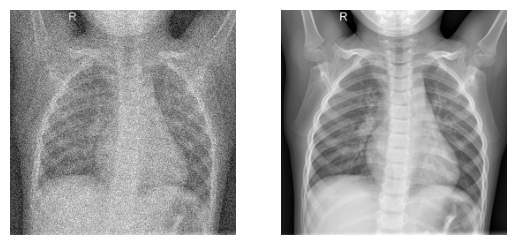

In [49]:
def test_dataloader():
    # if DISABLING_TESTS: return
    dataloader_train, dataloader_valid, dataloader_test = get_dataloaders(get_config())
    for i, (x, y) in enumerate(dataloader_train):
        print(f"Batch {i+1}")
        print(f"x size: {x.size()}")
        print(f"y size: {y.size()}")
        plt.subplot(1, 2, 1)
        plt.imshow(x.squeeze(0).squeeze(0).squeeze(-1).to("cpu"), cmap='gray')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(y.squeeze(0).squeeze(0).squeeze(-1).to("cpu"), cmap='gray')
        plt.axis('off')
        plt.show();
        if i == 5:
            break

test_dataloader()

------

### Training

#### Code for one epoch

In [50]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

def train_iteration(optimizer, model, loss_func, sample):
    optimizer.zero_grad(set_to_none=True)  # Zero your gradients for every batch!
    noisy_image, clean_image = sample
    # print(f"noisy_image size: {noisy_image.size()}")
    # print(f"clean_image size: {clean_image.size()}")
    denoised_image = model(noisy_image)
    loss = loss_func(denoised_image, clean_image)
    loss.backward()
    
    if loss.item() != loss.item():
        raise ValueError("NaN returned by loss function...")

    optimizer.step()

    denoised_image = denoised_image.squeeze(0).squeeze(0).squeeze(-1)
    clean_image = clean_image.squeeze(0).squeeze(0).squeeze(-1)

    psnr = PSNR(denoised_image, clean_image)
    ssim = SSIM(denoised_image, clean_image)

    return loss.item(), psnr, ssim

def train_epoch(model, data_loader, optimizer, loss_func) -> float:
    """Perform the training of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data_loader
        Dataloader with training data
    optimizer
        Pytorch optimizer, e.g. Adam
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        training loss

    Raises
    ------
    ValueError
        loss is NaN
    """
    running_loss = 0.
    running_psnr = 0.
    running_ssim = 0.
    num_batches = len(data_loader)
    # for sample in tqdm(data_loader): # tqdm helps show a nice progress bar
    for sample in data_loader:
        loss, psnr, ssim = train_iteration(optimizer, model, loss_func, sample)
        running_loss += loss
        running_psnr += psnr
        running_ssim += ssim
    avg_loss = running_loss / num_batches
    avg_psnr = running_psnr / num_batches
    avg_ssim = running_ssim / num_batches
    return avg_loss, avg_psnr, avg_ssim



def validate_iteration(model, loss_func, sample):
    noisy_image, clean_image = sample
    denoised_image = model(noisy_image)
    loss = loss_func(denoised_image, clean_image)

    # assert len(denoised_image.size()) == 5, f"Expected 5D tensor, got {denoised_image.size()}"
    denoised_image = denoised_image.squeeze(0).squeeze(0).squeeze(-1)
    clean_image = clean_image.squeeze(0).squeeze(0).squeeze(-1)

    psnr = PSNR(denoised_image, clean_image)
    ssim = SSIM(denoised_image, clean_image)

    return loss.item(), psnr, ssim

def validate_epoch(model, data_loader, loss_func) -> float:
    """Perform the validation of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data_loader
        Dataloader with validation data
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        validation loss
    """
    running_loss = 0.
    running_psnr = 0.
    running_ssim = 0.
    num_batches = len(data_loader)
    # for sample in tqdm(data_loader): # tqdm helps show a nice progress bar
    for sample in data_loader:
        loss, psnr, ssim = validate_iteration(model, loss_func, sample)
        running_loss += loss
        running_psnr += psnr
        running_ssim += ssim
    avg_loss = running_loss / num_batches
    avg_psnr = running_psnr / num_batches
    avg_ssim = running_ssim / num_batches
    return avg_loss, avg_psnr, avg_ssim



# def test_iteration(model, loss_func, sample):
#     noisy_image, clean_image = sample
#     denoised_image = model(noisy_image)
#     loss = loss_func(denoised_image, clean_image)

#     # assert len(denoised_image.size()) == 5, f"Expected 5D tensor, got {denoised_image.size()}"
#     denoised_image = denoised_image.squeeze(0).squeeze(0).squeeze(-1)
#     clean_image = clean_image.squeeze(0).squeeze(0).squeeze(-1)

#     psnr = PSNR(denoised_image, clean_image)
#     ssim = SSIM(denoised_image, clean_image)

#     return loss.item(), psnr, ssim

# def test_epoch(model, data_loader, loss_func) -> float:
#     """Perform the testing of one epoch.

#     Parameters
#     ----------
#     model
#         Model to be trained
#     data_loader
#         Dataloader with testing data
#     loss_func
#         Loss function to be calculated, e.g. MSE

#     Returns
#     -------
#         testing loss
#     """
    # running_loss = 0.
    # running_psnr = 0.
    # running_ssim = 0.
    # num_batches = len(data_loader)
    # # for sample in tqdm(data_loader): # tqdm helps show a nice progress bar
    # for sample in data_lsoader:
    #     loss, psnr, ssim = test_iteration(model, loss_func, sample)
    #     running_loss += loss
    #     running_psnr += psnr
    #     running_ssim += ssim
    # avg_loss = running_loss / num_batches
    # avg_psnr = running_psnr / num_batches
    # avg_ssim = running_ssim / num_batches
    # return avg_loss, avg_psnr, avg_ssim


#### Prep for training

In [51]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [52]:
def save_image(image_tensor_2D, image_name, folder_name):
    image_tensor_2D = torch.clamp(image_tensor_2D, 0, 1) # Clip the values to 0 and 1
    image_numpy = image_tensor_2D.to("cpu").detach().numpy()
    image_numpy_256 = image_numpy * 255
    image_numpy_256_uint8 = image_numpy_256.astype(np.uint8)
    image_to_save = Image.fromarray(image_numpy_256_uint8)  # TODO: Is there a shorter way to do this, similar to .convert("L")?
    image_to_save.save(f"{folder_name}/{image_name}.png")

In [53]:
def make_testcase():
    CHEST_XRAY_BASE_DATA_PATH = "../data/chest_xray"
    image = Image.open(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL/IM-0115-0001.jpeg")
    image = crop_to_square_and_resize(image, 512)

    folder_name = "testcases_tmp"

    image_name = "chest_xray_clean"
    image.save(f"{folder_name}/{image_name}.png") 

    # Add noise to the image
    noisy_image_tensor_4D = add_noise(convert_to_tensor_4D(convert_to_numpy(image)), sigma=0.5)
    noisy_image_tensor_2D = noisy_image_tensor_4D.squeeze(0).squeeze(-1)
    noisy_image_name = "chest_xray_noisy"
    save_image(noisy_image_tensor_2D, "chest_xray_noisy", folder_name)

    # Read the saved images
    clean_image = Image.open(f"{folder_name}/{image_name}.png")
    noisy_image = Image.open(f"{folder_name}/{noisy_image_name}.png")
    

    plt.subplot(1, 2, 1)
    plt.imshow(clean_image, cmap='gray')
    plt.axis('off')
    plt.title("Clean Image")
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')
    plt.title("Noisy Image")
    plt.show();

# make_testcase()

#### Optional: Use wandb to log the training process

In [54]:
# Optional: Use wandb to log the training process
# !wandb login
def init_wandb(config):
    project_name = config["project"]
    os.environ['WANDB_NOTEBOOK_NAME'] = project_name
    os.environ['WANDB_MODE'] = config["wandb_mode"] # https://docs.wandb.ai/quickstart
    wandb.login()
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project=project_name,

        # track hyperparameters and run metadata
        config=get_config(),
    )

In [55]:
# def temp_log_to_files():
#     model_states_dir = "tmp_2/model-chest_xray-2024_06_06_05_51_27"
#     config = get_config()
#     with open(f"{model_states_dir}/config.json", "w") as f:
#         json.dump(config, f, indent=4)
#     with open(f"{model_states_dir}/config.yaml", "w") as f:
#         yaml.dump(config, f)
#     with open(f"{model_states_dir}/config.txt", "w") as f:
#         f.write(str(config))

# def test_temp_log_to_files():
#     temp_log_to_files()

# test_temp_log_to_files()

#### Start training

In [59]:
# Code adapted from https://www.github.com/koflera/LearningRegularizationParameterMaps

def start_training(config, pretrained_model_path=None, is_state_dict=False, start_epoch=0):

    dataloader_train, dataloader_valid, dataloader_test = get_dataloaders(config)

    if pretrained_model_path is None or is_state_dict:
        # Define CNN block
        unet = UNet2d(
            in_channels=config["in_channels"],
            out_channels=config["out_channels"],
            init_filters=config["init_filters"],
            n_blocks=config["n_blocks"],
            activation=config["activation"],
            downsampling_kernel=config["downsampling_kernel"],
            downsampling_mode=config["downsampling_mode"],
            upsampling_kernel=config["upsampling_kernel"],
            upsampling_mode=config["upsampling_mode"],
        ).to(DEVICE)

        # Construct primal-dual operator with nn
        pdhg = DynamicImageStaticPrimalDualNN(
            cnn_block=unet, 
            T=config["T"],
            phase="training",
            up_bound=config["up_bound"],
        ).to(DEVICE)
        if is_state_dict:
            pdhg.load_state_dict(torch.load(f"{model_states_dir}/{pretrained_model_path}.pt"))
    else:
        pdhg = torch.load(f"{model_states_dir}/{pretrained_model_path}.pt")

    pdhg.train(True)

    # TODO: Sometimes, creating the optimizer gives this error:
    #   AttributeError: partially initialized module 'torch._dynamo' has no attribute 'trace_rules' (most likely due to a circular import)
    optimizer = torch.optim.Adam(pdhg.parameters(), lr=config["learning_rate"])
    loss_function = torch.nn.MSELoss()

    num_epochs = config["epochs"]

    save_epoch_local = config["save_epoch_local"]
    save_epoch_wandb = config["save_epoch_wandb"]

    time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    project = config["project"]
    model_name = f"model-{project}-{time}"

    # Prepare to save the model
    save_dir = config["save_dir"]
    model_states_dir = f"{save_dir}/{model_name}"

    os.makedirs(model_states_dir, exist_ok=True)

    def log_to_files():
        with open(f"{model_states_dir}/config.json", "w") as f:
            json.dump(config, f, indent=4)
        with open(f"{model_states_dir}/config.yaml", "w") as f:
            yaml.dump(config, f)
        with open(f"{model_states_dir}/config.txt", "w") as f:
            f.write(str(config))
        with open(f"{model_states_dir}/unet.txt", "w") as f:
            f.write(str(unet))
        with open(f"{model_states_dir}/pdhg_net.txt", "w") as f:
            f.write(str(pdhg))

        def log_data(dataloader, stage):
            dataset = dataloader.dataset
            with open(f"{model_states_dir}/dataloader_{stage}.txt", "w") as f:
                f.write(f"Batch size: {dataloader.batch_size}\n\n")
                f.write(f"Number of batches: {len(dataloader)}\n\n")
                f.write(f"Number of samples: {len(dataset)}\n\n")
                f.write(f"Samples weights:\n{str(dataset.samples_weights)}\n\n")
                f.write(f"Sample 0 size:\n{str(len(dataset[0]))}  {str(dataset[0][0].size())}\n\n")
                f.write(f"Sample 0:\n{str(dataset[0])}\n\n")
        log_data(dataloader_train, "train")
        log_data(dataloader_valid, "val")
        log_data(dataloader_test, "test")

    log_to_files()

    # noisy_image_path = "./testcases/chest_xray_noisy.png"
    # clean_image_path = "./testcases/chest_xray_clean.png"

    # def get_image(image_path):
    #     image = Image.open(image_path)
    #     image = image.convert("L")
    #     image_data = np.asarray(image)
    #     image_data = convert_to_tensor_4D(image_data)
    #     image_data = image_data.unsqueeze(0).to(DEVICE)
    #     return image_data

    # noisy_image_data = get_image(noisy_image_path)
    # clean_image_data = get_image(clean_image_path)

    # dataset_train = MyDataset(noisy_image_path, clean_image_path)
    # dataset_valid = MyDataset(noisy_image_path, clean_image_path)

    # dataloader_train = torch.utils.data.DataLoader(
    #     dataset_train, batch_size=1, 
    #     generator=torch.Generator(device=DEVICE),
    #     shuffle=True)
    # dataloader_valid = torch.utils.data.DataLoader(
    #     dataset_valid, batch_size=1, 
    #     generator=torch.Generator(device=DEVICE),
    #     shuffle=False)


    init_wandb(config)

    # for epoch in range(start_epoch, num_epochs):
    for epoch in tqdm(range(start_epoch, num_epochs)):

        # Model training
        pdhg.train(True)
        training_loss, training_psnr, training_ssim = train_epoch(pdhg, dataloader_train, optimizer, loss_function)
        # training_loss, training_psnr, training_ssim = train_iteration(optimizer, pdhg, loss_function, sample=(noisy_image_data, clean_image_data))
        pdhg.train(False)
        # print(f"Epoch {epoch+1} - TRAINING LOSS: {training_loss} - TRAINING PSNR: {training_psnr} - TRAINING SSIM: {training_ssim}")

        # Optional: Use wandb to log training progress
        wandb.log({"training_loss": training_loss})
        wandb.log({"training PSNR": training_psnr})
        wandb.log({"training SSIM": training_ssim})


        with torch.no_grad():
            torch.cuda.empty_cache()

            # Model validation
            validation_loss, validation_psnr, validation_ssim = validate_epoch(pdhg, dataloader_valid, loss_function)
            # validation_loss, validation_psnr, validation_ssim = validate_iteration(pdhg, loss_function, sample=(noisy_image_data, clean_image_data))
            # print(f"Epoch {epoch+1} - VALIDATION LOSS: {validation_loss} - VALIDATION PSNR: {validation_psnr} - VALIDATION SSIM: {validation_ssim}")
            time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

            # Optional: Use wandb to log training progress
            wandb.log({"validation_loss": validation_loss})
            wandb.log({"validation PSNR": validation_psnr})
            wandb.log({"validation SSIM": validation_ssim})

            torch.cuda.empty_cache()


        if (epoch+1) % save_epoch_local == 0:
            current_model_name = f"model_epoch_{epoch+1}"
            torch.save(pdhg, f"{model_states_dir}/{current_model_name}.pt")
            
            print(f"Epoch {epoch+1} - VALIDATION LOSS: {validation_loss} - VALIDATION PSNR: {validation_psnr} - VALIDATION SSIM: {validation_ssim}")

        if (epoch+1) % save_epoch_wandb == 0:
            wandb.log_model(f"{model_states_dir}/{current_model_name}.pt", name=f"model_epoch_{epoch+1}")
            
        torch.cuda.empty_cache()


    # Save the entire model
    torch.save(pdhg, f"{model_states_dir}/final_model.pt")
    
    wandb.log_model(f"{model_states_dir}/{current_model_name}.pt", name=f"final_model")
    wandb.finish()
    
    with torch.no_grad():
        torch.cuda.empty_cache()

    return pdhg

In [62]:
with torch.no_grad():
    torch.cuda.empty_cache()

pdhg = start_training(get_config())

with torch.no_grad():
    torch.cuda.empty_cache()

NameError: free variable 'dataloader_train' referenced before assignment in enclosing scope

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

------

### Inference

Demo the model

#### Test denoising

In [ ]:
# # CODE TO INFER AND SHOW SOME RESULTS HERE



# def simple_plot(input_image_tensor_5D, subplot_index, image_name, clean_image_tensor_5D, folder_name, num_rows=2, num_cols=3):
#     plot_image_tensor_2D = input_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     clean_image_tensor_2D = clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     psnr_value = PSNR(clean_image_tensor_2D, plot_image_tensor_2D)
#     ssim_value = SSIM(clean_image_tensor_2D, plot_image_tensor_2D)
#     plt.subplot(num_rows, num_cols, subplot_index)
#     plt.axis('off')
#     plt.imshow(plot_image_tensor_2D.to("cpu").detach().numpy(), cmap='gray')
#     plt.title(f"{image_name} PSNR: {psnr_value:.2f} dB\n{image_name} SSIM: {ssim_value:.2f}", fontsize=10)
#     # Write the image to a file
#     save_image(plot_image_tensor_2D, f"{image_name}", folder_name)

# def get_image_tensor_5D(image):
#     image = image.convert("L")
#     image_numpy = np.asarray(image)
#     image_tensor_4D = convert_to_tensor_4D(image_numpy)
#     image_tensor_5D = image_tensor_4D.unsqueeze(0).to(DEVICE)
#     return image_tensor_5D

# def denoise(pdhg: DynamicImageStaticPrimalDualNN, noisy_image_tensor_5D):
#     pdhg.eval()
#     with torch.no_grad():
#         best_lambda_map = pdhg.get_lambda_cnn(noisy_image_tensor_5D)
#     x_denoised_lambda_map_best_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, best_lambda_map, pdhg.T)
#     # x_denoised_lambda_map_best_tensor_5D = torch.clamp(x_denoised_lambda_map_best_tensor_5D, 0, 1)
#     with torch.no_grad():
#         torch.cuda.empty_cache()
#     return best_lambda_map, x_denoised_lambda_map_best_tensor_5D


# def brute_force_lambda(noisy_image_tensor_5D, clean_image_tensor_5D, T, min_value=0.01, max_value=0.1, num_values=10):
#     # TODO: Brute-force single lambda
#     best_psnr = 0
#     best_lambda = 0
#     lambas = list(np.linspace(min_value, max_value, num_values))
#     psnr_values = []
#     for lambda_value in lambas:
#         with torch.no_grad():
#             x_denoised_single_lambda_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, lambda_value, T)
#         psnr_value = PSNR(clean_image_tensor_5D, x_denoised_single_lambda_tensor_5D)
#         psnr_value = psnr_value.item()
#         # Convert to float
#         psnr_value = np.float64(psnr_value)
#         if psnr_value > best_psnr:
#             best_psnr = psnr_value
#             best_lambda = lambda_value
#         psnr_values.append(psnr_value)

#     # Plot the PSNR values
#     plt.plot(lambas, psnr_values)
#     plt.xlabel("Lambda")
#     plt.ylabel("PSNR")
#     plt.title("PSNR vs Lambda")
#     plt.show()
    
#     return best_lambda


# def test_denoise(pdhg: DynamicImageStaticPrimalDualNN=None, model_name="", best_lambda=None):
#     """
#     Testing denoising with pre-trained parameters.
#     """
#     clean_image = Image.open(f"testcases/chest_xray_clean.png")
#     noisy_image = Image.open(f"testcases/chest_xray_noisy.png")
#     clean_image_tensor_5D = get_image_tensor_5D(clean_image)
#     noisy_image_tensor_5D = get_image_tensor_5D(noisy_image)

#     if best_lambda is None:
#         best_lambda = brute_force_lambda(noisy_image_tensor_5D, clean_image_tensor_5D, T=pdhg.T, min_value=0.01, max_value=1, num_values=100)

#     print(f"Best lambda: {best_lambda}")

#     k_w, k_h = 256, 256

#     folder_name = f"./tmp/images/model_{model_name}-kernel_{k_w}-best_lambda_{str(best_lambda).replace('.', '_')}-time_{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
#     os.makedirs(folder_name, exist_ok=True)

#     plt.figure(figsize=(15, 6)) # Set the size of the plot

#     simple_plot(clean_image_tensor_5D, 1, "clean", clean_image_tensor_5D, folder_name)
#     simple_plot(noisy_image_tensor_5D, 2, "noisy", clean_image_tensor_5D, folder_name)

#     x_denoised_single_lambda_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, best_lambda, T=pdhg.T)
    
#     best_lambda_map, x_denoised_lambda_map_tensor_5D = denoise(pdhg, noisy_image_tensor_5D)

#     # Clip to [0, 1]. The calculations may make it slightly below 0 and above 1
#     x_denoised_single_lambda_tensor_5D = torch.clamp(x_denoised_single_lambda_tensor_5D, 0, 1)
#     x_denoised_lambda_map_tensor_5D = torch.clamp(x_denoised_lambda_map_tensor_5D, 0, 1)

#     simple_plot(x_denoised_single_lambda_tensor_5D, 3, f"single_lambda_best_{str(best_lambda).replace('.', '_')}", clean_image_tensor_5D, folder_name)
#     simple_plot(x_denoised_lambda_map_tensor_5D, 4, "lambda_map_best_using_function", clean_image_tensor_5D, folder_name)

#     lambda_map_1 = best_lambda_map[:, 0:1, :, :, :]
#     lambda_map_2 = best_lambda_map[:, 1:2, :, :, :]
#     lambda_map_3 = best_lambda_map[:, 2:3, :, :, :]

#     lambda_map_1 = torch.clamp(lambda_map_1, 0, 1)
#     lambda_map_2 = torch.clamp(lambda_map_2, 0, 1)
#     lambda_map_3 = torch.clamp(lambda_map_3, 0, 1)

#     simple_plot(lambda_map_1, 5, "lambda_map_1", clean_image_tensor_5D, folder_name)
#     simple_plot(lambda_map_3, 6, "lambda_map_3", clean_image_tensor_5D, folder_name)

#     plt.savefig(f"{folder_name}/results.png")

#     plt.show();

#     with open(f"{folder_name}/log.txt", "w") as f:
#         f.write(f"Best lambda: {best_lambda}\n")
#         f.write(f"PSNR (single lambda): {PSNR(clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1), x_denoised_single_lambda_tensor_5D.squeeze(0).squeeze(0).squeeze(-1))}\n")
#         f.write(f"PSNR (lambda map): {PSNR(clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1), x_denoised_lambda_map_tensor_5D.squeeze(0).squeeze(0).squeeze(-1))}\n")
#         f.write(f"Config: {get_config()}\n")

#     with torch.no_grad():
#         torch.cuda.empty_cache()

# model_dir = "./tmp_2/model-2024_06_05_23_51_27"
# epoch = 4000
# pdhg = torch.load(f"{model_dir}/model_epoch_{epoch}.pt")

# test_denoise(
#     pdhg=pdhg,
#     model_name=f"chest_xray_demo-epoch_{epoch}",
#     best_lambda=0.08
# )

# with torch.no_grad():
#     torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# def temp_test():

---

### Create a video

In [ ]:
# def create_video(model_name, start_epoch=20, end_epoch=10_000, step=20):
#     clean_image_path = "./test_cases/turtle_clean/turtle clean.png"
#     noisy_image_path = "./test_cases/turtle_noisy/turtle noisy.png"
#     clean_image_tensor_5D = get_image_tensor_5D(clean_image_path)
#     noisy_image_tensor_5D = get_image_tensor_5D(noisy_image_path)
#     clean_image_tensor_2D = clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     noisy_image_tensor_2D = noisy_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)

#     psnr_noisy = PSNR(noisy_image_tensor_2D, clean_image_tensor_2D)
#     ssim_noisy = SSIM(noisy_image_tensor_2D, clean_image_tensor_2D)



#     frames_folder = f"./tmp/{model_name}"
#     model_folder=f"./tmp_2/{model_name}"
#     os.makedirs(frames_folder, exist_ok=True)
#     os.makedirs(f"{frames_folder}/denoised", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_1", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_2", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_3", exist_ok=True)

#     with open(f"./tmp/{model_name}/metrics.csv", "w") as f:
#         f.write(f"Image, PSNR, SSIM\n")
#         f.write(f"Noisy, {psnr_noisy:.2f}, {ssim_noisy:.2f}\n")

#         for epoch in range(start_epoch, end_epoch + 1, step):
#             model_name = f"model_epoch_{epoch}"
#             pdhg = torch.load(f"{model_folder}/{model_name}.pt")
#             best_lambda_map, x_denoised_lambda_map_best_tensor_5D = denoise(pdhg, noisy_image_tensor_5D)
#             x_denoised_lambda_map_best_tensor_5D = torch.clamp(x_denoised_lambda_map_best_tensor_5D, 0, 1)

#             x_denoised_lambda_map_best_tensor_2D = x_denoised_lambda_map_best_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#             psnr_denoised = PSNR(x_denoised_lambda_map_best_tensor_2D, clean_image_tensor_2D)
#             ssim_denoised = SSIM(x_denoised_lambda_map_best_tensor_2D, clean_image_tensor_2D)
#             f.write(f"{epoch}, {psnr_denoised:.2f}, {ssim_denoised:.2f}\n")

#             denoised_image_to_save = Image.fromarray((x_denoised_lambda_map_best_tensor_2D.to("cpu").detach().numpy() * 255).astype(np.uint8))
#             denoised_image_to_save.save(f"{frames_folder}/denoised/{epoch}.png")

#             lambda_map_1 = best_lambda_map[:, 0:1, :, :, :]
#             lambda_map_2 = best_lambda_map[:, 1:2, :, :, :]
#             lambda_map_3 = best_lambda_map[:, 2:3, :, :, :]
#             lambda_map_1 = torch.clamp(lambda_map_1, 0, 1)
#             lambda_map_2 = torch.clamp(lambda_map_2, 0, 1)
#             lambda_map_3 = torch.clamp(lambda_map_3, 0, 1)

#             lambda_map_1_to_save = Image.fromarray((lambda_map_1.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_1_to_save.save(f"{frames_folder}/lambda_map_1/{epoch}.png")

#             lambda_map_2_to_save = Image.fromarray((lambda_map_2.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_2_to_save.save(f"{frames_folder}/lambda_map_2/{epoch}.png")

#             lambda_map_3_to_save = Image.fromarray((lambda_map_3.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_3_to_save.save(f"{frames_folder}/lambda_map_3/{epoch}.png")
        

#     # # Create the video
#     # frames = []
#     # for epoch in range(start_epoch, end_epoch + 1, step):
#     #     frames.append(cv2.imread(f"{frames_folder}/frame_{epoch}.png"))
#     # height, width, layers = frames[0].shape
#     # size = (width, height)
#     # out = cv2.VideoWriter(f"{frames_folder}/video.avi", cv2.VideoWriter_fourcc(*'DIVX'), 1, size)
#     # for i in range(len(frames)):
#     #     out.write(frames[i])
#     # out.release()

# create_video("model_turtle_2024_06_04_04_19_21", start_epoch=20, end_epoch=10_000, step=20)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# def test_revisualise():

#     def vis(image_folder, image_name):
#         image_path = f"{image_folder}/{image_name}.png"
#         image = Image.open(image_path)
#         plt.imshow(image, cmap='gray')
#         plt.show();

#     image_folder = "tmp/PRESENT/presentation-img_turtle-best_lambda_0_07-kernel_256-model_-trained_on_-time_2024_06_04_22_59_31-epoch_100_000"
#     image_names = [
#         "lambda_map_3",
#         "single_lambda_best_0_06000000000000001",
#         "clean",
#     ]

#     for image_name in image_names:
#         vis(image_folder, image_name)

# test_revisualise()